In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone -b feature/add_rl_part https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 568 (delta 113), reused 50 (delta 37), pack-reused 380 (from 3)
Receiving objects: 100% (568/568), 265.13 KiB | 11.53 MiB/s, done.
Resolving deltas: 100% (323/323), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.9/259.9 kB 12.1 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=98a7994ab3290

In [2]:
import sys
import pathlib

repo_root = pathlib.Path("/kaggle/working/multimodal-eq-sizing")
sys.path.append(str(repo_root))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from src.backtest.simulator import simulate_policy
from src.backtest.behavior_policy import compute_behavior_actions_for_day
from src.backtest.metrics import summarize_backtest, summary_to_series
from src.rl.cql_agent import CQLAgentTF
from src.backtest.metrics import _drawdown_curve

2025-12-02 00:43:02.369357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764636182.687689      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764636182.774620      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
df_policy = pd.read_csv("/kaggle/input/04-train-cql-and-fqe/df_policy_dataset.csv")
policy_model = keras.models.load_model("/kaggle/input/04-train-cql-and-fqe/cql_q_policy.keras")

2025-12-02 00:43:25.725771: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
z_col='dummy_z'
state_cols = [z_col, "VIX_z", "spread_z", 'weight_after_guards']

In [7]:
def dumb_policy_fn(day_df: pd.DataFrame, prev_w: pd.Series) -> pd.Series:
    # prev_w is unused by the dumb policy, but we accept it for interface uniformity
    actions = compute_behavior_actions_for_day(
        day_df,
        z_col=z_col
    )
    return actions

In [8]:
BUCKET_MAP = {0: 0.0, 1: 0.01, 2: 0.02}

def make_rl_policy_fn(policy_model, state_cols):
    """
    Build a policy_fn for simulate_policy that uses a trained Q-policy model.

    policy_model: Keras model mapping state -> Q(s, ·)
    state_cols:   list of column names to use in the state vector,
                  e.g. ["z", "vix_z", "spread_z", "weight_after_guards", "has_news", ...]
    """
    def rl_policy_fn(day_df: pd.DataFrame, prev_w: pd.Series) -> pd.Series:
        df = day_df.copy()

        # If your state in training included prev_weight, reconstruct it here:
        if "prev_weight" in state_cols and "prev_weight" not in df.columns:
            df["prev_weight"] = prev_w.reindex(df["ticker"]).fillna(0.0).values

        # Build state matrix in the same order as during training
        X = df[state_cols].to_numpy().astype("float32")  # [N, state_dim]

        # Q-values from the policy model
        q_vals = policy_model(X, training=False).numpy()  # [N, n_actions]

        # Greedy discrete action index
        act_idx = np.argmax(q_vals, axis=1)  # [N]

        # Map indices -> buckets in weight space
        weights = [BUCKET_MAP[int(i)] for i in act_idx]

        return pd.Series(weights, index=df["ticker"].values, name="action_weight_raw")

    return rl_policy_fn
rl_policy_fn = make_rl_policy_fn(policy_model, state_cols)

In [9]:
bt_dumb = simulate_policy(
    df_policy,
    policy_fn=dumb_policy_fn,
    z_col=z_col
)

bt_rl = simulate_policy(
    df_policy,
    policy_fn=rl_policy_fn,
    z_col=z_col
)

In [10]:
summ_dumb = summarize_backtest(bt_dumb)
summ_rl   = summarize_backtest(bt_rl)

df_summ = pd.concat(
    [
        summary_to_series(summ_dumb, "dumb"),
        summary_to_series(summ_rl,   "rl"),
    ],
    axis=1,
).T

display(df_summ)

,CAGR,AnnVol,Sharpe,MaxDD,Calmar,HitRate,AvgDailyRet,AvgDailyTurnover,AnnTurnover,AvgGrossExposure
dumb,-0.00063,0.004212,-0.149598,-0.023827,-0.026445,0.458683,-0.000002,0.025526,6.432623,0.025526
rl,0.00000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


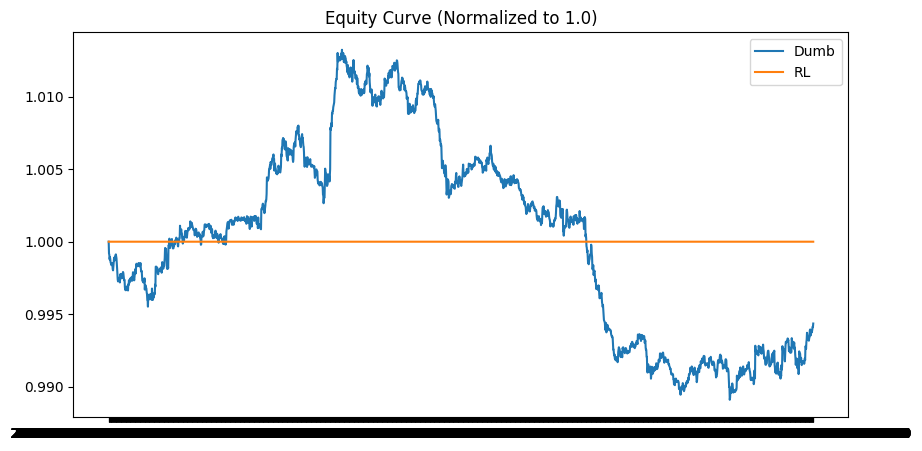

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(bt_dumb["Date"], bt_dumb["nav"] / bt_dumb["nav"].iloc[0], label="Dumb")
plt.plot(bt_rl["Date"],   bt_rl["nav"]   / bt_rl["nav"].iloc[0],   label="RL")
plt.legend()
plt.title("Equity Curve (Normalized to 1.0)")
plt.show()

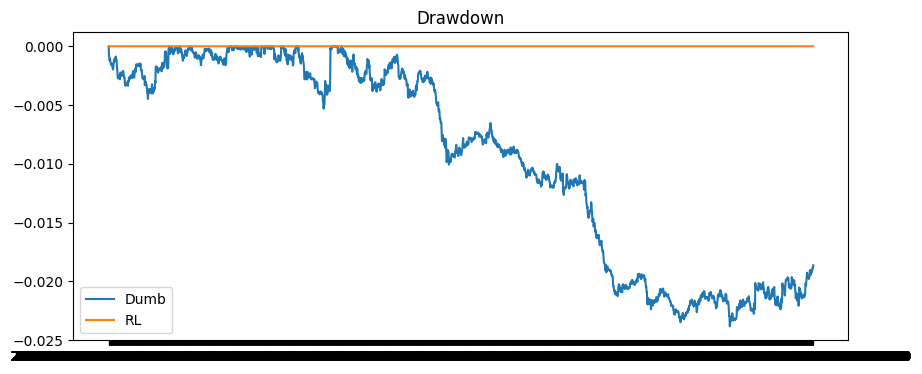

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(bt_dumb["Date"], _drawdown_curve(bt_dumb["nav"]), label="Dumb")
plt.plot(bt_rl["Date"],   _drawdown_curve(bt_rl["nav"]),   label="RL")
plt.legend()
plt.title("Drawdown")
plt.show()